## Bibliotecas Utilizadas

In [1]:
import pandas as pd
import numpy as np

import missingno

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt


## Importação dos dados

A opção <code>na_value=' '</code> serve para transformar strings vazias presentes nos arquivos .csv em valores nulos para os datasets

In [2]:
df_train = pd.read_csv('data/train.csv', na_values=' ')
df_test = pd.read_csv('data/test.csv', na_values=' ')

In [3]:
id_test = df_test['id_solicitante']

In [4]:
pd.set_option('display.max_columns', None)

df_train.head(3)

,id_solicitante,produto_solicitado,dia_vencimento,forma_envio_solicitacao,tipo_endereco,sexo,idade,estado_civil,qtde_dependentes,grau_instrucao,nacionalidade,estado_onde_nasceu,estado_onde_reside,possui_telefone_residencial,codigo_area_telefone_residencial,tipo_residencia,meses_na_residencia,possui_telefone_celular,possui_email,renda_mensal_regular,renda_extra,possui_cartao_visa,possui_cartao_mastercard,possui_cartao_diners,possui_cartao_amex,possui_outros_cartoes,qtde_contas_bancarias,qtde_contas_bancarias_especiais,valor_patrimonio_pessoal,possui_carro,vinculo_formal_com_empresa,estado_onde_trabalha,possui_telefone_trabalho,codigo_area_telefone_trabalho,meses_no_trabalho,profissao,ocupacao,profissao_companheiro,grau_instrucao_companheiro,local_onde_reside,local_onde_trabalha,inadimplente
0,1,1,10,presencial,1,M,85,2,0,0,1,CE,CE,Y,107.0,1.0,12.0,N,0,480.0,0.0,0,0,0,0,0,1,1,0.0,1,N,NaN,N,NaN,0,9.0,1.0,0.0,0.0,600.0,600.0,0
1,2,1,25,internet,1,F,38,1,0,0,1,SE,SE,Y,91.0,1.0,5.0,N,1,380.0,0.0,0,0,0,0,0,0,0,0.0,0,N,NaN,N,NaN,0,2.0,5.0,NaN,NaN,492.0,492.0,0
2,3,1,20,internet,1,F,37,2,0,0,1,BA,BA,Y,90.0,5.0,1.0,N,1,600.0,0.0,0,0,0,0,0,0,0,0.0,0,N,NaN,N,NaN,0,NaN,NaN,NaN,NaN,450.0,450.0,1


## Visualização dos dados

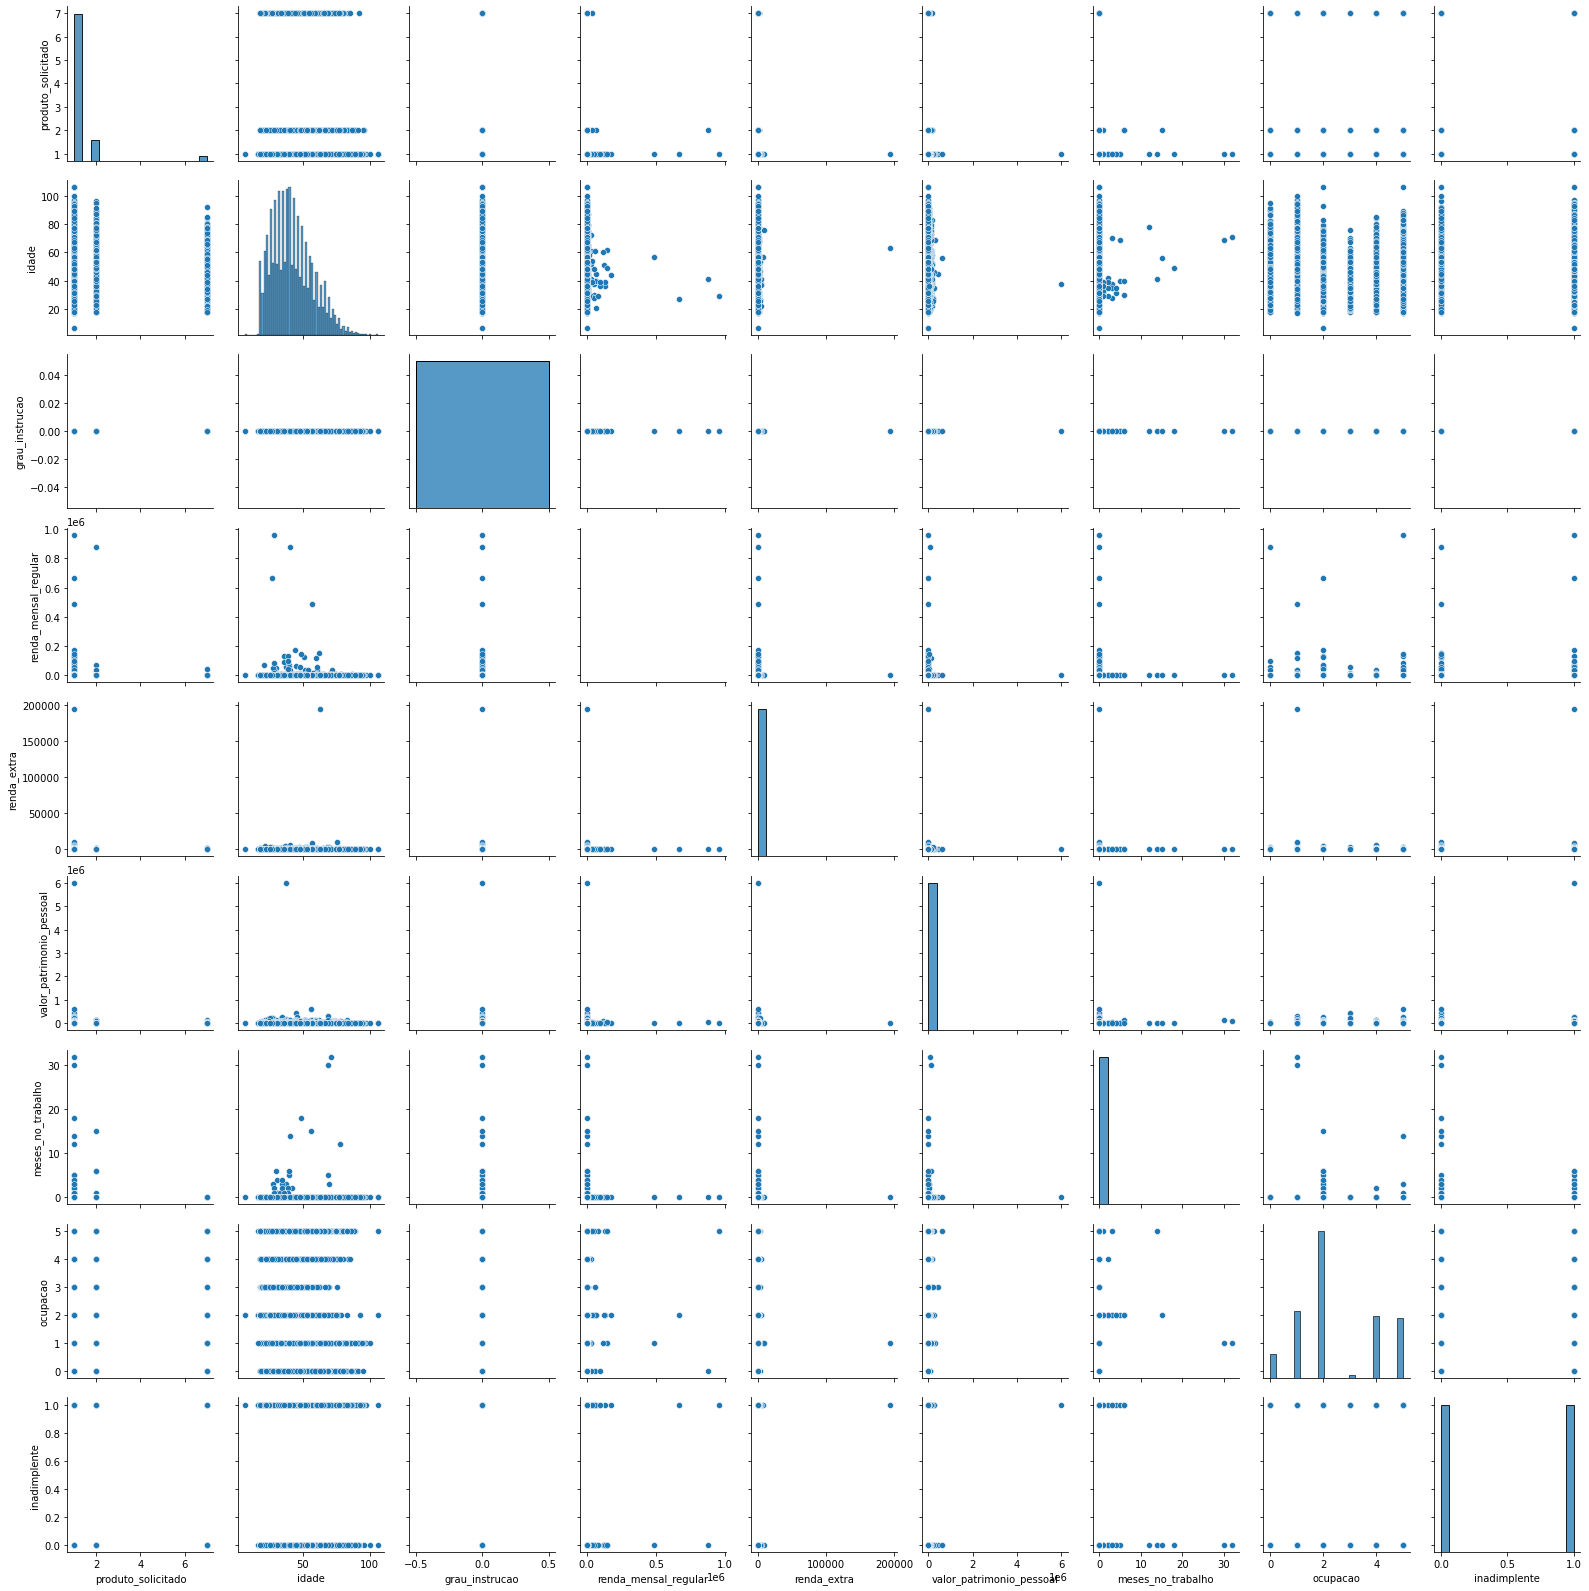

In [5]:
columns_to_plot = ['produto_solicitado','idade','estado_onde_reside', 'grau_instrucao', 'renda_mensal_regular','renda_extra','valor_patrimonio_pessoal','vinculo_formal_com_empresa','meses_no_trabalho','ocupacao','inadimplente']
sns.pairplot(df_train[columns_to_plot])

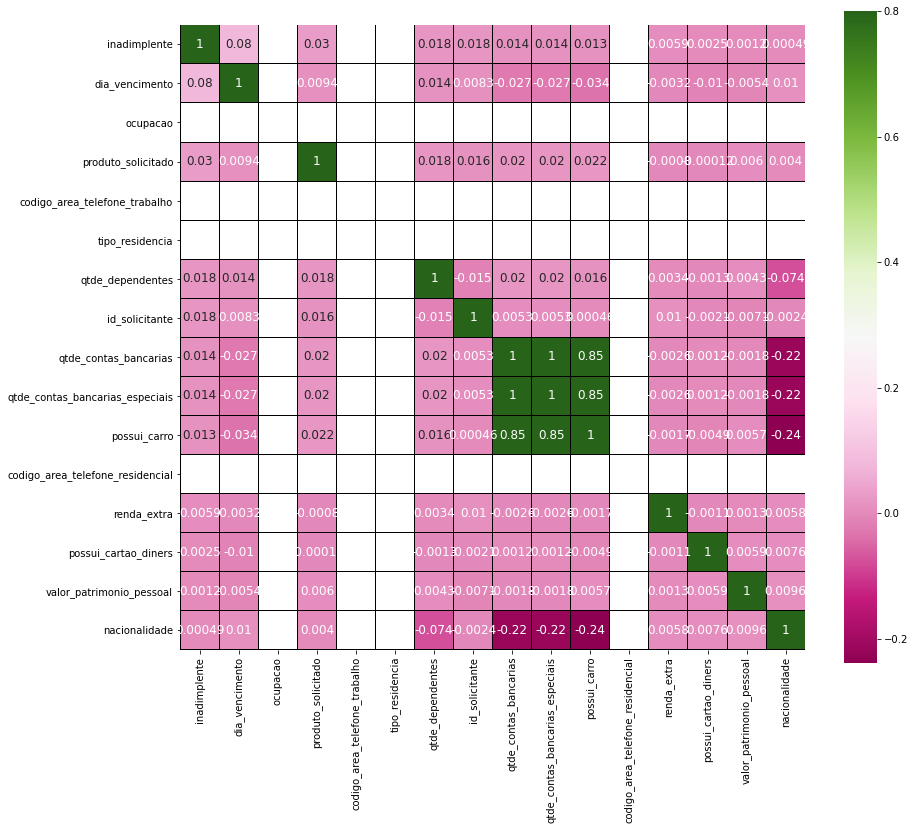

In [6]:
correlation = df_train.corr()

k = len([i for i in correlation['inadimplente'] if abs(i) >= 0.015])
cols = correlation.nlargest(k,'inadimplente')['inadimplente'].index
cm = np.corrcoef(df_train[cols].values.T)
f , ax = plt.subplots(figsize = (14,12))
sns.heatmap(cm, vmax=.8, linewidths=0.01,square=True,annot=True,cmap="PiYG",
            linecolor="black",xticklabels = cols.values ,annot_kws = {'size':12},yticklabels = cols.values)
plt.show()

Como é possível notar, existem poucas variáveis com alguma correlação signficativa com a de inadimplência

## Remoção de colunas dos datasets

As colunas de código de área de telefones e estado onde o consumidor nasceu, trabalha ou reside não são valiosas para nossa análise, além do número elevado de estados que deveria ser codificados, aumentando o tamanho do dataset desnecessariamente

In [7]:
columns_to_drop = ['id_solicitante', 'estado_onde_nasceu', 'codigo_area_telefone_residencial', 
                   'codigo_area_telefone_trabalho', 'estado_onde_trabalha', 'estado_onde_reside']

df_train = df_train.drop(columns=columns_to_drop)
df_test = df_test.drop(columns=columns_to_drop)


## Transformando dados para binários

In [8]:
df_train = df_train.replace({'N': 0, 'Y': 1})
df_test = df_test.replace({'N': 0, 'Y': 1})

df_train = df_train.replace({'M': 0, 'F': 1})
df_test = df_test.replace({'M': 0, 'F': 1})


## <it>One-hot Encoder para coluna <code>forma_envio_solicitacao</code>

In [9]:
df_train = pd.get_dummies(df_train, columns=['forma_envio_solicitacao'])
df_test = pd.get_dummies(df_test, columns=['forma_envio_solicitacao'])


In [10]:
df_train.head(10)

,produto_solicitado,dia_vencimento,tipo_endereco,sexo,idade,estado_civil,qtde_dependentes,grau_instrucao,nacionalidade,possui_telefone_residencial,tipo_residencia,meses_na_residencia,possui_telefone_celular,possui_email,renda_mensal_regular,renda_extra,possui_cartao_visa,possui_cartao_mastercard,possui_cartao_diners,possui_cartao_amex,possui_outros_cartoes,qtde_contas_bancarias,qtde_contas_bancarias_especiais,valor_patrimonio_pessoal,possui_carro,vinculo_formal_com_empresa,possui_telefone_trabalho,meses_no_trabalho,profissao,ocupacao,profissao_companheiro,grau_instrucao_companheiro,local_onde_reside,local_onde_trabalha,inadimplente,forma_envio_solicitacao_correio,forma_envio_solicitacao_internet,forma_envio_solicitacao_presencial
0,1,10,1,0.0,85,2,0,0,1,1,1.0,12.0,0,0,480.0,0.0,0,0,0,0,0,1,1,0.0,1,0,0,0,9.0,1.0,0.0,0.0,600.0,600.0,0,0,0,1
1,1,25,1,1.0,38,1,0,0,1,1,1.0,5.0,0,1,380.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,2.0,5.0,NaN,NaN,492.0,492.0,0,0,1,0
2,1,20,1,1.0,37,2,0,0,1,1,5.0,1.0,0,1,600.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,NaN,NaN,NaN,NaN,450.0,450.0,1,0,1,0
3,1,20,1,0.0,37,1,1,0,1,1,1.0,1.0,0,1,460.0,0.0,0,0,0,0,0,0,0,0.0,0,1,1,0,9.0,2.0,NaN,NaN,932.0,932.0,1,0,1,0
4,7,1,1,1.0,51,1,3,0,1,1,0.0,1.0,0,1,687.0,600.0,0,0,0,0,0,0,0,0.0,1,1,0,0,9.0,5.0,NaN,NaN,440.0,440.0,1,0,1,0
5,1,20,1,0.0,21,1,1,0,1,1,5.0,2.0,0,0,382.0,0.0,1,0,0,0,0,0,0,0.0,1,1,1,0,9.0,2.0,0.0,0.0,628.0,628.0,1,0,0,1
6,1,15,1,1.0,64,4,2,0,1,1,1.0,0.0,0,1,350.0,0.0,0,0,0,0,0,1,1,0.0,1,0,0,0,10.0,1.0,0.0,0.0,190.0,190.0,1,0,0,1
7,1,5,1,1.0,20,1,0,0,1,1,1.0,5.0,0,1,800.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,NaN,NaN,NaN,NaN,299.0,299.0,1,0,1,0
8,2,25,1,1.0,39,2,2,0,1,1,1.0,3.0,0,1,1200.0,0.0,1,0,0,0,0,0,0,0.0,0,1,1,0,9.0,2.0,9.0,4.0,756.0,756.0,0,0,1,0
9,1,10,1,0.0,44,2,2,0,1,0,1.0,15.0,0,0,749.0,0.0,0,0,0,0,0,1,1,0.0,1,1,0,0,9.0,2.0,16.0,4.0,960.0,960.0,1,0,0,1


## Tratando dados faltantes

Valores nulos foram substituídos pela mediana

In [11]:
df_train.isna().sum()

produto_solicitado                        0
dia_vencimento                            0
tipo_endereco                             0
sexo                                      7
idade                                     0
estado_civil                              0
qtde_dependentes                          0
grau_instrucao                            0
nacionalidade                             0
possui_telefone_residencial               0
tipo_residencia                         536
meses_na_residencia                    1450
possui_telefone_celular                   0
possui_email                              0
renda_mensal_regular                      0
renda_extra                               0
possui_cartao_visa                        0
possui_cartao_mastercard                  0
possui_cartao_diners                      0
possui_cartao_amex                        0
possui_outros_cartoes                     0
qtde_contas_bancarias                     0
qtde_contas_bancarias_especiais 

In [12]:
df_train.fillna(df_train.median(), inplace=True)
df_test.fillna(df_test.median(), inplace=True)

## Treinando os modelos

Os modelos de Random Forest, Gradient Boosting e AdaBoost (baseado no Decision Tree Classifier) foram selecionados e treinados com os mesmos dados. Diversos hiperparâmetros de cada foram explorados pela biblioteca GridSearchCV, com 10 validações cruzadas, e os melhores foram escolhidos de acordo com a maior acurácia obtida. Estes valores se encontram abaixo da célula de execução de cada modelo

In [13]:
X_train = df_train.drop(columns='inadimplente')
y_train = df_train['inadimplente']

X_test = df_test

In [14]:
random_forest = RandomForestClassifier(random_state=42)

param_grid = {"class_weight": ['balanced'],
    "max_depth": [5,10,15],
    "n_estimators": [10,50,100],
    "criterion": ['gini', 'entropy']}

grid_search_rf = GridSearchCV(random_forest, param_grid, cv=10, scoring='accuracy')

grid_search_rf.fit(X_train,y_train)

print('Accuracy: %.3f' % grid_search_rf.best_score_)
print('Config: %s' % grid_search_rf.best_params_)

Accuracy: 0.589
Config: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'n_estimators': 100}


In [15]:
gradient_boosting = GradientBoostingClassifier(random_state=42)

param_grid = {"max_features":["log2", "sqrt"],
    "criterion": ["friedman_mse",  "mse"],
    "subsample":[0.5, 0.75, 1.0],
    "n_estimators":[100],
    "max_depth": [3, 4, 5],
    "learning_rate": [ 0.1, 0.2, 0.3]}

grid_search_gb = GridSearchCV(gradient_boosting, param_grid, cv=10, scoring='accuracy')

grid_search_gb.fit(X_train,y_train)

print('Accuracy: %.3f' % grid_search_gb.best_score_)
print('Config: %s' % grid_search_gb.best_params_)

Accuracy: 0.601
Config: {'criterion': 'friedman_mse', 'learning_rate': 0.2, 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 100, 'subsample': 1.0}


In [ ]:
ada_boost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=42,)

param_grid = {'base_estimator__min_samples_leaf':[5,10],
              'n_estimators':[10,100,250],
              'learning_rate':[0.01,0.1]}


grid_search_ab = GridSearchCV(ada_boost, param_grid, cv=10, scoring='accuracy')

grid_search_ab.fit(X_train,y_train)

print('Accuracy: %.3f' % grid_search_ab.best_score_)
print('Config: %s' % grid_search_ab.best_params_)

## Conclusões

<ol>
    <li>O modelo de Gradient Boosting apresentou maior acurácia tanto com os dados de treino quanto com a submissão parcial no Kaggle, e foi o escolhido para a predição final.</li>
    <li>O preenchimento de valores nulos e vazios pela mediana foi de grande ajuda para os modelos</li>
    <li>A exclusão de colunas desnecessárias foi responsável por um aumento significativo da performance dos modelos</li>
</ol>

In [ ]:
y_test = grid_search_gb.predict(X_test)
submission = pd.DataFrame(
{
    'id_solicitante': id_test, 
    'inadimplente': y_test.astype(int),
})
submission.to_csv(f"submission.csv", index=False)
